#### autoreload modules and utilities

In [1]:
%reload_ext autoreload
%autoreload

#### import all neceesary libraries/packages

In [2]:
import joblib
import os
import random

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

from wordcloud import WordCloud

from sklearn.pipeline import Pipeline 
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report

#### Import necessary utilities

The utilities file is for cleaning of the text

In [1]:
## utilities
from utils import clean_text, CleanTextTransformer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DHREY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DHREY\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DHREY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load all the data

We will be using Amazon_Consumer_Reviews dataset

In [4]:
def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname), encoding="utf-8") as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname), encoding="utf-8") as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((np.array(train_texts), np.array(train_labels)),
            (np.array(test_texts), np.array(test_labels)))

In [5]:
(X_train, y_train), (X_test, y_test) = load_imdb_sentiment_analysis_dataset(data_path='data/aclImdb_v1')

## Rename the columns

In [6]:
train = pd.DataFrame(X_train, columns=['text'])
train['rating'] = y_train
train.head()

,text,rating
0,POSSIBLE SPOILERS<br /><br />The Spy Who Shagg...,0
1,"The long list of ""big"" names in this flick (in...",0
2,Bette Midler showcases her talents and beauty ...,1
3,Great movie when I saw it. Have to say one of ...,1
4,Although it's most certainly politically incor...,1


## Labeling of Responses



In [7]:
train['label'] = train["rating"].apply(lambda x: "positive" if x else "negative")
train.head()

,text,rating,label
0,POSSIBLE SPOILERS<br /><br />The Spy Who Shagg...,0,negative
1,"The long list of ""big"" names in this flick (in...",0,negative
2,Bette Midler showcases her talents and beauty ...,1,positive
3,Great movie when I saw it. Have to say one of ...,1,positive
4,Although it's most certainly politically incor...,1,positive


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   rating  25000 non-null  int32 
 2   label   25000 non-null  object
dtypes: int32(1), object(2)
memory usage: 488.4+ KB


### Missing values

In [9]:
train.isnull().sum()

text      0
rating    0
label     0
dtype: int64

###### We check for the sum of missing values if there exist any, fortunately there is no missing value in the dataset 

### Label Frequency

positive    12500
negative    12500
Name: label, dtype: int64



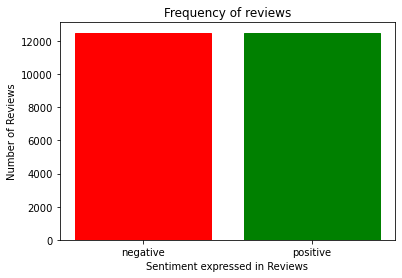

In [10]:
Index = [0, 1]

print(train["label"].value_counts())
print()

barlist = plt.bar(Index, train["label"].value_counts())

plt.title("Frequency of reviews")
plt.xticks(Index, ['negative', 'positive'])
plt.ylabel('Number of Reviews')
plt.xlabel('Sentiment expressed in Reviews')

barlist[Index[1]].set_color('green')
barlist[Index[0]].set_color('red')
plt.show()

## Train with TfidfVector and Bernoulli NB


#### initilize pipeline with TfidfVector

In [11]:
tfidf_NB = Pipeline([
    ("clean_text", cleanTextTransformer()),
    ('tfidf',TfidfVectorizer(stop_words="english")),
    ('classifier', BernoulliNB())
])

In [12]:
tfidf_NB.fit(X_train, y_train)

Pipeline(steps=[('clean_text', cleanTextTransformer()),
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('classifier', BernoulliNB())])

#### Creating joblib for deploment

In [13]:
joblib.dump(tfidf_NB, "models/bernoulli_naive_bayes_with_tfidf_vectorizer.joblib")

['models/bernoulli_naive_bayes_with_tfidf_vectorizer.joblib']

## Prediction and Report

In [14]:
y_pred = tfidf_NB.predict(X_test) #predict testing data

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83     12500
           1       0.87      0.75      0.80     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



### Training with Countvectorizer and BernoulliNB

In [15]:
cv_NB = Pipeline([
    ("clean_text", cleanTextTransformer()),
    ('bow', CountVectorizer(stop_words="english")),
    ('classifier',BernoulliNB())
])

In [16]:
cv_NB.fit(X_train,y_train)

Pipeline(steps=[('clean_text', cleanTextTransformer()),
                ('bow', CountVectorizer(stop_words='english')),
                ('classifier', BernoulliNB())])

#### Creating joblib for deploment

In [17]:
joblib.dump(cv_NB, "models/bernoulli_naive_bayes_with_count_vectorizer.joblib")

['models/bernoulli_naive_bayes_with_count_vectorizer.joblib']

## Prediction and Report

In [18]:
y_pred = cv_NB.predict(X_test) #predict testing data

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83     12500
           1       0.87      0.75      0.80     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



In [19]:
type(X_train)

numpy.ndarray

### Running Cross validation with TfidfvVectorizer and BernoulliNB

In [20]:
accuracy = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=100) 
skf.get_n_splits(X_train, y_train) 

for train_index, test_index in skf.split(X_train, y_train):
    x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    tfidf_NB.fit(x_train_fold, y_train_fold)
    result = tfidf_NB.score(x_test_fold, y_test_fold)
    accuracy.append(result)

accuracy = np.array(accuracy)

# Print the output
print('List of first 10 possible accuracy:')
for index, acc in enumerate(accuracy[:10]):
    print(f"{index+1:3d}. {acc:.4f}")

print('\nMetrics that were obtained from this model:')
print(f' Maximum Accuracy:   {accuracy.max()*100:.2f}%') 
print(f' Minimum Accuracy:   {accuracy.min()*100:.2f}%') 
print(f' Mean Accuracy:      {accuracy.mean()*100:.2f}%') 
print(f' Standard Deviation: {accuracy.std():.4f}')

List of first 10 possible accuracy:
  1. 0.8576
  2. 0.8372
  3. 0.8448
  4. 0.8452
  5. 0.8528
  6. 0.8552
  7. 0.8500
  8. 0.8604
  9. 0.8504
 10. 0.8480

Metrics that were obtained from this model:
 Maximum Accuracy:   86.04%
 Minimum Accuracy:   83.72%
 Mean Accuracy:      85.02%
 Standard Deviation: 0.0065


### Running Cross validation with Countvectorizer and BernoulliNB

In [24]:
accuracy = []

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=100) 
skf.get_n_splits(X_train ,y_train) 

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index] 
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    cv_NB.fit(X_train_fold, y_train_fold)
    result = cv_NB.score(X_test_fold, y_test_fold)
    accuracy.append(result)


accuracy = np.array(accuracy)

# Print the output
print('List of first 10 possible accuracy:')
for index, acc in enumerate(accuracy[:10]):
    print(f"{index+1:3d}. {acc:.4f}")

print('\nMetrics that were obtained from this model:')
print(f' Maximum Accuracy:   {accuracy.max()*100:.2f}%') 
print(f' Minimum Accuracy:   {accuracy.min()*100:.2f}%') 
print(f' Mean Accuracy:      {accuracy.mean()*100:.2f}%') 
print(f' Standard Deviation: {accuracy.std():.4f}')

MemoryError: Unable to allocate 1.15 GiB for an array with shape (22500,) and data type <U13704